# Predicting stock prices using LSTM
## Introduction
This notebook demos a method of implementing an LSTM neural network to forecast future stock prices


## Import libraries

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import timedelta, datetime
print('Libraries imported!')

Libraries imported!


## Import dataset

In [94]:
filepath = './data/san_fransisco_weather.csv'
df = pd.read_csv(filepath)
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')
df.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PSUN,TAVG,TMAX,TMIN,WSF1
0,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,1972-01-01,99.0,NaN,14.4,8.3,NaN
1,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,1972-01-02,100.0,NaN,11.7,3.9,NaN
2,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,1972-01-03,100.0,NaN,12.2,5.6,NaN
3,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,1972-01-04,100.0,NaN,10.0,5.6,NaN
4,USW00023272,"SAN FRANCISCO DOWNTOWN, CA US",37.7705,-122.4269,45.7,1972-01-05,100.0,NaN,12.2,4.4,NaN


In [95]:
df.describe().style.format("{:,.2f}")

,LATITUDE,LONGITUDE,ELEVATION,PSUN,TAVG,TMAX,TMIN,WSF1
count,"18,263.00","18,263.00","18,263.00","1,096.00","1,614.00","18,261.00","18,261.00",2.00
mean,37.77,-122.43,45.70,63.62,14.14,18.07,10.82,8.00
std,0.00,0.00,0.00,34.58,3.01,4.33,2.52,0.00
min,37.77,-122.43,45.70,0.00,4.40,2.80,-2.20,8.00
25%,37.77,-122.43,45.70,37.00,12.20,15.00,9.40,8.00
50%,37.77,-122.43,45.70,73.00,13.90,17.80,11.10,8.00
75%,37.77,-122.43,45.70,96.00,15.60,20.00,12.20,8.00
max,37.77,-122.43,45.70,100.00,30.00,41.10,23.90,8.00


## Prepare dataset
From the brief summary of the dataset above we can see that there are some missing values. We will try and forcast the maximum daily temperature as that contains the fewest missing datapoints (could also forcast minimums). We can also see that all the readings are from the same location, so we can drop all the location based data.

In [96]:
# keep required datetime and temperature data
temp_df = df.loc[:, ['DATE', 'TMAX']]
temp_df.head()

,DATE,TMAX
0,1972-01-01,14.4
1,1972-01-02,11.7
2,1972-01-03,12.2
3,1972-01-04,10.0
4,1972-01-05,12.2


In [97]:
# inspect missing values
temp_df[temp_df.TMAX.isna()]

,DATE,TMAX
9088,1996-11-18,NaN
9089,1996-11-19,NaN


There are only two missing data values which is not too significant relative to the complete dataset, they are next to each other which means the backfill method will result in them both having the same value. This is not ideal but is unlikely to have a significant impact here.

In [98]:
# backfill missing values
temp_df.bfill(inplace=True)

We need to check that the data is uniformly spaced in time:

In [99]:
# create copy of time column
test = temp_df.loc[:,['DATE']].copy()
# Shift the index by one
test['time_gap'] = test.DATE - test.DATE.shift(1)
# Print the results
test.describe()

,time_gap
count,18262
mean,1 days 00:00:04.731135691
std,0 days 00:10:39.351330454
min,1 days 00:00:00
25%,1 days 00:00:00
50%,1 days 00:00:00
75%,1 days 00:00:00
max,2 days 00:00:00


We can see that the data is predominantly distributed with a time step of 1 day, but not all rows have this, so we need to find where they are and correct this.

In [100]:
test[test.time_gap != timedelta(days=1)]

,DATE,time_gap
0,1972-01-01,NaT
16860,2018-03-01,2 days


In [101]:
test.iloc[[16859, 16860, 16861]]

,DATE,time_gap
16859,2018-02-27,1 days
16860,2018-03-01,2 days
16861,2018-03-02,1 days


This dataset is missing data for the 28th Feb 2018, we need to add in an extra row, and backfill the values, same as we did previously.

In [102]:
# add the new row
temp_df.loc[-1] = pd.Series([datetime(2018, 2, 28), temp_df.TMAX.iloc[16859]], index=['DATE', 'TMAX'], name=-1)
# Sort the DataFrame by date
temp_df = temp_df.sort_values(by='DATE', ascending=False)
# Reindex the DataFrame
temp_df = temp_df.reset_index(drop=True)

# check the problem is solved using the same method as before
# create copy of time column
test = temp_df.loc[:,['DATE']].copy()
# Shift the index by one
test['time_gap'] = test.DATE - test.DATE.shift(1)
# Print the results
test[test.time_gap != timedelta(days=1)]

,DATE,time_gap
0,2022-01-01,NaT
1,2021-12-31,-1 days
2,2021-12-30,-1 days
3,2021-12-29,-1 days
4,2021-12-28,-1 days
...,...,...
18259,1972-01-05,-1 days
18260,1972-01-04,-1 days
18261,1972-01-03,-1 days
18262,1972-01-02,-1 days


## Visualise dataset


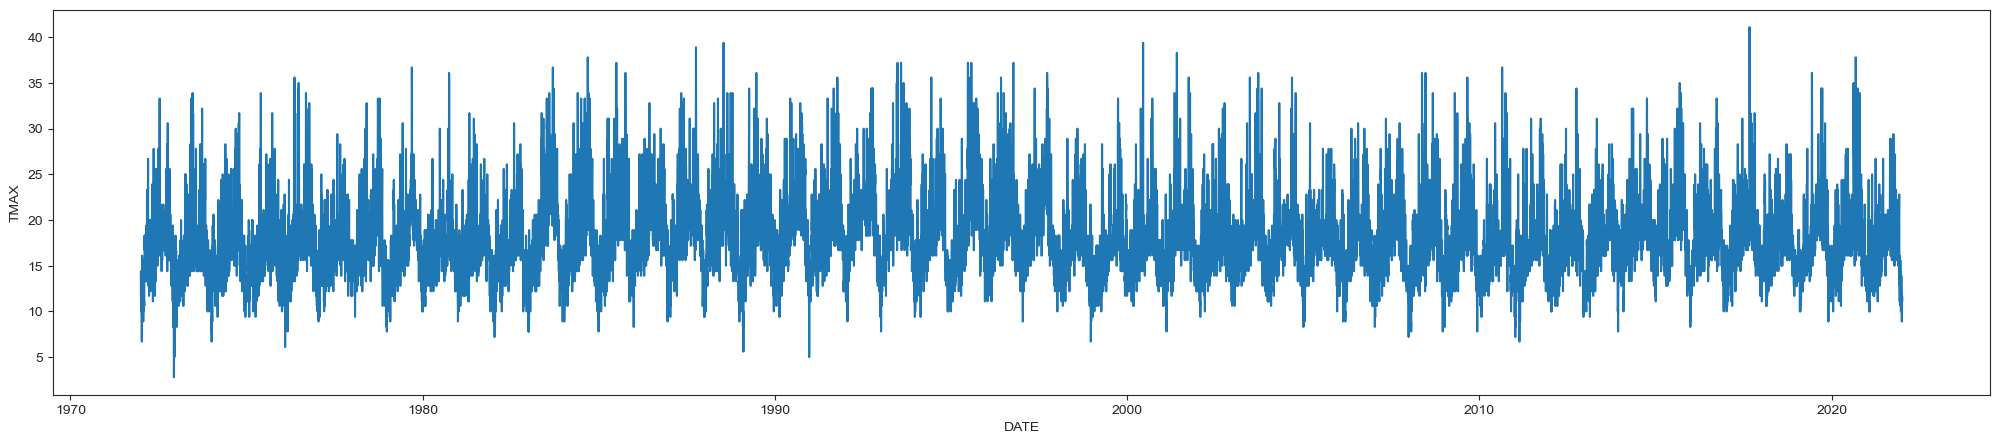

In [103]:
sns.set_style("ticks")
plt.figure(figsize=(25,5))
sns.lineplot(x=temp_df['DATE'], y=temp_df['TMAX'])
plt.show()

From the plots above it is clear that there is a distinct pattern over each year, this is what would be expected from the temperature in a seasonal location.

## Reshape data for training
To train the LSTM model we need to shape the data into windowed rows, so each row contains the previous n timesteps of temperature data.

In [104]:
n = 10  # number of timesteps back per row

# create each time shifted column
for i in range(1,n+1):
    temp_df[f'TMAX_{i}'] = temp_df.TMAX.shift(-i)

In [106]:
# drop the last rows which will contain NaN values
temp_df.dropna(inplace=True)

In [112]:
temp_df #.describe().style.format("{:,.2f}")

,DATE,TMAX,TMAX_1,TMAX_2,TMAX_3,TMAX_4,TMAX_5,TMAX_6,TMAX_7,TMAX_8,TMAX_9,TMAX_10
0,2022-01-01,11.1,11.7,11.7,9.4,8.9,10.6,10.0,11.7,12.2,13.9,11.7
1,2021-12-31,11.7,11.7,9.4,8.9,10.6,10.0,11.7,12.2,13.9,11.7,11.7
2,2021-12-30,11.7,9.4,8.9,10.6,10.0,11.7,12.2,13.9,11.7,11.7,12.2
3,2021-12-29,9.4,8.9,10.6,10.0,11.7,12.2,13.9,11.7,11.7,12.2,10.0
4,2021-12-28,8.9,10.6,10.0,11.7,12.2,13.9,11.7,11.7,12.2,10.0,11.1
...,...,...,...,...,...,...,...,...,...,...,...,...
18249,1972-01-15,15.6,16.1,9.4,12.8,6.7,13.3,12.8,13.3,11.7,13.9,12.2
18250,1972-01-14,16.1,9.4,12.8,6.7,13.3,12.8,13.3,11.7,13.9,12.2,10.0
18251,1972-01-13,9.4,12.8,6.7,13.3,12.8,13.3,11.7,13.9,12.2,10.0,12.2
18252,1972-01-12,12.8,6.7,13.3,12.8,13.3,11.7,13.9,12.2,10.0,12.2,11.7


Now the data needs to be split into a training and test set, we will keep 3 years to test the model on, and train with 27 years.

In [115]:
test_size = 365*3
# split into train and test
test_df = temp_df[-test_size:]
train_df = temp_df[:-test_size]

# split up x and y
x_test = test_df.drop(['DATE', 'TMAX'], axis=1)
x_train = train_df.drop(['DATE', 'TMAX'], axis=1)
y_test = test_df['TMAX']
y_train = train_df['TMAX']

In [122]:
# save as csv files

x_test.to_csv('./data/x_test.csv', index=False)
y_test.to_csv('./data/y_test.csv', index=False)
x_train.to_csv('./data/x_train.csv', index=False)
y_train.to_csv('./data/y_train.csv', index=False)

print('Saved dataframes as csv files')

Saved dataframes as csv files
